In [1]:
import sys
sys.path.append("../../")

import requests
import io
import pandas as pd
import numpy as np
import outputformat as ouf
from datetime import datetime
import re
from sklearn.metrics import roc_curve,auc
import matplotlib.pyplot as plt
import pickle

import spacy
from pprint import pprint
from transformers import AutoModelForQuestionAnswering, AutoTokenizer, pipeline
from itertools import combinations

import bechdelai.data.wikipedia as wiki
import bechdelai.data.tmdb as tmdb
from bechdelai.data.display import show_movie_suggestions_get_id

In [2]:
def age(birthdate,release_date):
    # Difference in years 
    year_difference = release_date.year - birthdate.year
    
    # Check if birthday happened before or after release date
    one_or_zero = ((release_date.month, release_date.day) < (birthdate.month, birthdate.day))
        
    # If release before birthday -> substract 1
    # If release after birthday -> substract 0
    age = year_difference - one_or_zero
        
    return age

def compute_cast_age(cast_df,release_date):
    age_at_release = np.repeat(None,len(cast_df))
    for i,row in cast_df.iterrows():
        birthday = tmdb.get_person_details_from_id(row['id'])['birthday']
        try:
            age_at_release[i] = age(datetime.strptime(birthday, '%Y-%m-%d'),release_date)
        except TypeError:
            age_at_release[i] = None
    return age_at_release
    

def get_tmdb_cast_data(query,release_year):
    data = tmdb.search_movie_from_query(query)
    
    # find most probable id -> same (or closest) release year
    movie_id = ''
    release_year_error = np.Inf # should be min
    # look at the 5 first matches to choose the one that was release closer to release_year
    for res in data["results"][:5]:
        if ('release_date' not in res.keys()):
            continue
        try:
            res_release_year = int(res['release_date'][:4])
        except ValueError:
            continue
        if res_release_year==release_year:
            movie_id = res['id']
            break
        elif abs(res_release_year-release_year)<release_year_error:
            movie_id = res['id']
            release_year_error = abs(res_release_year-release_year)
    
    
    # get release date
    release_date = tmdb.get_movie_details_from_id(movie_id)['release_date']
    release_date = datetime.strptime(release_date, '%Y-%m-%d')
    # get casting data
    data = tmdb.get_movie_cast_from_id(movie_id)
    cast_df = pd.DataFrame(data["cast"])
    
    # only use simple quotation marks'
    cast_df.replace(regex=r'\"',value="'",inplace=True) 
    
    #remove any accents
    cast_df['name'] = cast_df['name'].str.normalize('NFKD').str.encode('ascii', errors='ignore').str.decode('utf-8')
    cast_df['character'] = cast_df['character'].str.normalize('NFKD').str.encode('ascii', errors='ignore').str.decode('utf-8')

    # complete with actors/actress ages
    cast_df['age_at_release'] = compute_cast_age(cast_df,release_date)

    return cast_df

def get_character_short_name(name):
    '''
    Characters' names as they are extracted from TMDB can be formatted in different ways.
    When characters are refered by a nickname, it's commonly presented between \' or \"
    
    '''
    nickname = re.search(r'(\'|\")(.*?)(\'|\")',name)
    if nickname == None:
        name = name.split(' ')[0]
    else:
        name = nickname.group(2)
    return name

def get_character_nickname(name):
    '''
    Characters' names as they are extracted from TMDB can be formatted in different ways.
    When characters are refered by a nickname, it's commonly presented between \' or \"
    
    '''
    nickname = re.search(r'(\'|\")(.*?)(\'|\")',name)
    if nickname != None:
        name = nickname.group(2)
    return name

def get_character_from_actor(cast_data,actor):
    '''
    Find in cast_data the character who was played by the actor/actress
    '''
    character = cast_data.loc[cast_data.name==actor,'character']
    if len(character):
        return character.values[0]
    else:
        return None # return None when actor/actress name is not found in the cast data

def get_actor_from_character(cast_data,character):
    '''
    Find in cast_data the actor/actress who played the character
    '''
    # to be sure that regex works, remove parenthesis
    character = character.replace('(','')
    character = character.replace(')','')
    character = character.replace('"',"'")# only use '
    
    # look for character's name match with all names in character (consider that middle names can be missing from character)
    pattern = '\s.*'.join(character.split(' '))+'.?(\s|$)' 
    # \s makes sure name ends (so characters like Phuong's Sister, Franz's girlfiend are not included)
    actor = cast_data[cast_data.character.str.contains(pattern)]['name'].values
    
    if not len(actor):
        # character name with all names not found in cast_data
        for character_name in character.split(' '):
            pattern = character_name+'(\s|$)'
            actor = cast_data[cast_data.character.str.contains(pattern)]['name'].values        
            if len(actor):
                break
    
    if not len(actor): 
        # character's name still not found
        return None
    elif len(actor)==1:
        # only one actor corresponding to character
        return actor[0]
    else:
        # multiple actors/resses, return as a list
        return list(actor)
    
def get_actor_age_at_release(cast_data,actor):
    return cast_data[cast_data.name==actor,'age_at_release']
    
def get_age_gap(cast_data,couple):
    
    # If any of the actor/actress in the couple was not identified (None), return NaN
    if (couple[0]==None) | (couple[1]==None):
        return np.nan, None
    
    # To compute the age gap, we must have identified exactly 1 actor/actress for each character (that are not the same)
    if (type(couple[0])==list) | (type(couple[1])==list) | (couple[0]==couple[1]):
        return np.nan, None
    
    # get data for each person
    person0 = cast_data[cast_data.name==couple[0]]
    if not len(person0):
        return np.nan, None
    age0 = person0.age_at_release.values[0]
    gender0 = person0.gender.values[0]
    
    person1 = cast_data[cast_data.name==couple[1]]
    if not len(person1):
        return np.nan, None
    age1 = person1.age_at_release.values[0]
    gender1 = person1.gender.values[0]
    
    # if age is not defined for any person
    if (age0==None) | (age1==None):
        return np.nan,[gender0,gender1]
    
    # if both are from same gender, use absolute difference
    if gender0==gender1:
        return abs(age0-age1),[gender0,gender1]
    else:
        return abs(age0-age1),[gender0,gender1]

    
def get_character_couples(cast_data,couples_actors):
    couples = []
    for couple in couples_actors:
        couples.append([get_character_from_actor(cast_data,actor) for actor in couple])
    return couples

def get_actor_couples(cast_data,couples_characters):
    couples = []
    for couple in couples_characters:
        couples.append(frozenset([get_actor_from_character(cast_data,character) for character in couple]))
    couples = set(couples)
    couples = [list(couple) for couple in couples]
    return couples
    
def import_hollywood_age_gap_dataset():
    url = 'https://hollywoodagegap.com/movies.csv'
    url_data = requests.get(url, allow_redirects=True).content
    hw_age_gap = pd.read_csv(io.StringIO(url_data.decode('utf-8')))
    hw_age_gap.columns = ['title','releaseYear','director','age_difference',
                          'name1','name1_gender','name1_birthdate','name1_age',
                          'name2','name2_gender','name2_birthdate','name2_age']
    #remove any accents
    hw_age_gap['name1'] = hw_age_gap['name1'].str.normalize('NFKD').str.encode('ascii', errors='ignore').str.decode('utf-8')
    hw_age_gap['name2'] = hw_age_gap['name2'].str.normalize('NFKD').str.encode('ascii', errors='ignore').str.decode('utf-8')
    return hw_age_gap

def is_couple_true(couples_truth,couple_test):
    return (couple_actors in couples_actors_truth) | (couple_actors[::-1] in couples_actors_truth)

In [3]:
couples_hollywood = import_hollywood_age_gap_dataset()

In [4]:
nlp = spacy.load('en_core_web_lg')
# Load model
model_name = "deepset/roberta-base-squad2"
qa = pipeline('question-answering', model=model_name, tokenizer=model_name, top_k=1)
verb = ['is in love with','is in couple with']#['kisses', 'sleeps with', 'has sex with', 'marries', 'is in love with','is in couple with']


In [5]:
def style_high_score(v, thres=0.5):
    try:
        return 'color:red;' if v > thres else None
    except TypeError:
        return None


In [7]:
# ans = pd.read_pickle('couples_detection.pkl')

In [6]:
unique_movies = couples_hollywood[['title','releaseYear']].drop_duplicates()
ans = pd.DataFrame(columns = ['movie','characters','actors','couple_truth']+verb)

for i,(movie,release_year) in unique_movies[:20].iterrows():
    
    ouf.boxtitle(movie)
    
    # From Hollywood Age Gap dataset:
#     release_year = couples_hollywood.loc[couples_hollywood.title==movie,'releaseYear'].iloc[0]
    couples_actors_truth = couples_hollywood[(couples_hollywood['title']==movie) & (couples_hollywood['releaseYear']==release_year)][['name1','name2']].values
    couples_actors_truth = [list(couple) for couple in couples_actors_truth]
    
    # get Plot from Wikipedia page
    for query_suffix in [' (film)',' ('+str(release_year)+' film)','']:
        try:
            sections = wiki.get_section_text(movie+query_suffix,['Plot'])
            if len(sections):
                document_string  = sections['Plot']
#                 print(document_string)
                break
        except ValueError:
            continue
    if not len(sections):
        print('Movie plot not found.')
        continue
    
    # Get cast data from TMDB
    cast_data = get_tmdb_cast_data(movie,release_year)
    
    # add to ans couples from Hollywood Age Gap database
    for couple in couples_actors_truth:
        new_entry = {'movie':movie,
                      'characters':get_character_couples(cast_data,[couple])[0],
                      'actors':couple,
                      'couple_truth': 1}
        for v in verb:
            new_entry.update({v:0})
        ans = ans.append(new_entry,ignore_index=True)
    
    # Prediction -> Combine characters and questions    
    people = [get_character_nickname(name) for name in cast_data.character]
        
    for context in document_string.split('\n'):
        if not len(context):
            continue
        for v in verb:
            for p in people:
                QA_input = {
                    'question': 'Who {} {}?'.format(v,p),
                    'context': context
                }
                a = qa(QA_input)
                
                couple_characters = [p,a['answer']]
                couple_actors = [get_actor_from_character(cast_data,character) for character in couple_characters]
                
                # was this couple previously detected?
                couple_in_ans = [((row.actors==couple_actors) or (row.actors==couple_actors[::-1])) and (row.movie==movie) for i,row in ans.iterrows()]
                if sum(couple_in_ans): # if this couple appeared before
                    previous_score = ans.loc[couple_in_ans,v].iloc[0]
                    ans.loc[couple_in_ans,v] = np.nanmax([previous_score,a['score']])
                else: # if it is the first time a couple appears
                    ans = ans.append({'movie':movie,
                                      'characters':couple_characters,
                                      'actors':couple_actors,
                                      v:a['score'],
                                      'couple_truth':  is_couple_true(couples_actors_truth,couple_actors)},ignore_index=True)
    
    # if true couple were not detected, add to ans with scores=0
    for couple in couples_actors_truth:
        # was this couple detected
        couple_in_ans = [((row.actors==couple) or (row.actors==couple[::-1])) and (row.movie==movie) for i,row in ans.iterrows()]
        if sum(couple_in_ans)==0: # if this couple never appeared before
            new_entry = {'movie':movie,
                          'characters':get_character_couples(cast_data,[couple])[0],
                          'actors':couple,
                          'couple_truth': 1}
            for v in verb:
                new_entry.update({v:0})
            ans = ans.append(new_entry,ignore_index=True)

                    
    
    ouf.b('Hollywood Age Gap dataset')
    pprint(list(couples_actors_truth))
    ouf.b('\nDetected couples')
    couples_detected = ans.loc[(np.nanmax(ans[verb],axis=1)>0.5) & (ans.movie.values == movie),['actors']+verb]
    display(couples_detected.style.applymap(style_high_score, thres=0.5))
display(ans.style.applymap(style_high_score, thres=0.3))

╭──────────────────╮
│ Harold and Maude │
╰──────────────────╯


/home/juliana/anaconda3/lib/python3.8/site-packages/pandas/core/strings/accessor.py:101: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  return func(self, *args, **kwargs)


Hollywood Age Gap dataset
[['Bud Cort', 'Ruth Gordon']]

Detected couples


,actors,is in love with,is in couple with
0,"['Bud Cort', 'Ruth Gordon']",0.817754,0.853524


╭───────╮
│ Venus │
╰───────╯


/home/juliana/anaconda3/lib/python3.8/site-packages/pandas/core/strings/accessor.py:101: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  return func(self, *args, **kwargs)


Hollywood Age Gap dataset
[["Peter O'Toole", 'Jodie Whittaker']]

Detected couples


,actors,is in love with,is in couple with
35,"[""Peter O'Toole"", 'Jodie Whittaker']",0.812019,0.330817
51,"['Sam Kenyon', ""Peter O'Toole""]",0.820761,0.221132
55,"['Bronson Webb', ""Peter O'Toole""]",0.506200,0.379754


╭────────────────────╮
│ The Quiet American │
╰────────────────────╯


/home/juliana/anaconda3/lib/python3.8/site-packages/pandas/core/strings/accessor.py:101: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  return func(self, *args, **kwargs)


Hollywood Age Gap dataset
[['Michael Caine', 'Do Thi Hai Yen'], ['Brendan Fraser', 'Do Thi Hai Yen']]

Detected couples


,actors,is in love with,is in couple with
70,"['Michael Caine', 'Do Thi Hai Yen']",0.203687,0.582409
101,"['Brendan Fraser', None]",0.191187,0.784742


╭──────────────────╮
│ The Big Lebowski │
╰──────────────────╯


/home/juliana/anaconda3/lib/python3.8/site-packages/pandas/core/strings/accessor.py:101: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  return func(self, *args, **kwargs)


Hollywood Age Gap dataset
[['David Huddleston', 'Tara Reid'], ['Jeff Bridges', 'Julianne Moore']]

Detected couples


,actors,is in love with,is in couple with
153,"['Jeff Bridges', 'Julianne Moore']",0.662760,0.635191
200,"['Jeff Bridges', 'Tara Reid']",0.154682,0.556612
201,"['John Goodman', 'Steve Buscemi']",0.000750,0.515688
229,"['Ajgie Kirkland', 'Tara Reid']",0.390035,0.515462


╭───────────╮
│ Beginners │
╰───────────╯
Movie plot not found.
╭────────────╮
│ Poison Ivy │
╰────────────╯


/home/juliana/anaconda3/lib/python3.8/site-packages/pandas/core/strings/accessor.py:101: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  return func(self, *args, **kwargs)


Hollywood Age Gap dataset
[['Tom Skerritt', 'Drew Barrymore']]

Detected couples


,actors,is in love with,is in couple with
351,"['Tom Skerritt', 'Drew Barrymore']",0.266677,0.512601
352,"['Drew Barrymore', 'Sara Gilbert']",0.583577,0.437887
354,"['Cheryl Ladd', 'Drew Barrymore']",0.610795,0.870749


╭────────────────╮
│ Whatever Works │
╰────────────────╯


/home/juliana/anaconda3/lib/python3.8/site-packages/pandas/core/strings/accessor.py:101: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  return func(self, *args, **kwargs)


Hollywood Age Gap dataset
[['Larry David', 'Evan Rachel Wood'],
 ['Larry David', 'Jessica Hecht'],
 ['Henry Cavill', 'Evan Rachel Wood']]

Detected couples


,actors,is in love with,is in couple with
416,"['Larry David', 'Jessica Hecht']",0.587193,0.803577
418,"['Larry David', None]",0.406676,0.575050
422,"['Ed Begley Jr.', 'Larry David']",0.000025,0.687850
427,"['Adam Brooks', None]",0.462491,0.557439
428,"['Lyle Kanouse', None]",0.427364,0.519834
445,"['Henry Cavill', None]",0.844176,0.881384
474,"['Jessica Hecht', ['Larry David', 'Michael McKean', 'Adam Brooks', 'Lyle Kanouse']]",0.767432,0.881025
485,"['Adam Brooks', 'Conleth Hill']",0.326025,0.520264
496,"['Kristen Ruhlin', 'Henry Cavill']",0.280438,0.584479
500,"['Conleth Hill', 'Patricia Clarkson']",0.655425,0.962676


╭────────────╮
│ Entrapment │
╰────────────╯


/home/juliana/anaconda3/lib/python3.8/site-packages/pandas/core/strings/accessor.py:101: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  return func(self, *args, **kwargs)


Hollywood Age Gap dataset
[['Sean Connery', 'Catherine Zeta-Jones']]

Detected couples


,actors,is in love with,is in couple with
543,"['Sean Connery', 'Catherine Zeta-Jones']",0.234963,0.538577


╭────────────────────╮
│ Husbands and Wives │
╰────────────────────╯


/home/juliana/anaconda3/lib/python3.8/site-packages/pandas/core/strings/accessor.py:101: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  return func(self, *args, **kwargs)


Hollywood Age Gap dataset
[['Woody Allen', 'Juliette Lewis'],
 ['Sydney Pollack', 'Judy Davis'],
 ['Woody Allen', 'Mia Farrow']]

Detected couples


,actors,is in love with,is in couple with
636,"['Sydney Pollack', 'Judy Davis']",0.581029,0.797114
639,"['Judy Davis', 'Mia Farrow']",0.742166,0.503466
643,"['Lysette Anthony', 'Sydney Pollack']",0.264006,0.525163
657,"[['John Doumanian', 'Gordon Rigsby'], 'Sydney Pollack']",0.140183,0.544646
689,"['Judy Davis', 'Liam Neeson']",0.823757,0.775051


╭──────────╮
│ Magnolia │
╰──────────╯


/home/juliana/anaconda3/lib/python3.8/site-packages/pandas/core/strings/accessor.py:101: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  return func(self, *args, **kwargs)


Hollywood Age Gap dataset
[['Jason Robards', 'Julianne Moore'], ['John C. Reilly', 'Melora Walters']]

Detected couples


,actors,is in love with,is in couple with
782,"['Jason Robards', 'Julianne Moore']",0.591286,0.931380
783,"['John C. Reilly', 'Melora Walters']",0.361512,0.734631
785,"[['Philip Baker Hall', 'Thomas Jane'], 'Melora Walters']",0.520151,0.844151
794,"['Melinda Dillon', ['Philip Baker Hall', 'Thomas Jane']]",0.304090,0.844120
807,"['Thomas Jane', 'Melora Walters']",0.553220,0.815192
827,"['Holly Houston', 'Melora Walters']",0.502192,0.632406
882,"[['Robert Bella', 'Tom Ohmer'], 'Melora Walters']",0.174331,0.524216
932,"['Thomas Jane', 'Jeremy Blackman']",0.672014,0.356108
1203,"['Douglas Busby', 'Julianne Moore']",0.073382,0.669668
1356,"[['Frank Elmore', 'Lionel Mark Smith', 'Robert Bella', 'Tom Ohmer'], 'Melora Walters']",0.148547,0.538929


╭─────────────────────────────╮
│ Mr. Peabody and the Mermaid │
╰─────────────────────────────╯


/home/juliana/anaconda3/lib/python3.8/site-packages/pandas/core/strings/accessor.py:101: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  return func(self, *args, **kwargs)


Hollywood Age Gap dataset
[['William Powell', 'Ann Blyth']]

Detected couples


,actors,is in love with,is in couple with
1548,"['William Powell', 'Irene Hervey']",nan,0.757707
1551,"['Clinton Sundberg', 'Irene Hervey']",0.934543,0.920180


╭──────────────╮
│ First Knight │
╰──────────────╯


/home/juliana/anaconda3/lib/python3.8/site-packages/pandas/core/strings/accessor.py:101: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  return func(self, *args, **kwargs)


Hollywood Age Gap dataset
[['Sean Connery', 'Julia Ormond'], ['Richard Gere', 'Julia Ormond']]

Detected couples


,actors,is in love with,is in couple with
1569,"['Sean Connery', 'Julia Ormond']",0.295058,0.851380
1570,"['Richard Gere', 'Julia Ormond']",0.517337,0.242854
1572,"['Richard Gere', 'Ben Cross']",0.244606,0.835976
1590,"['Richard Gere', 'Sean Connery']",0.286884,0.789210


╭────────────────────────╮
│ Something's Gotta Give │
╰────────────────────────╯


/home/juliana/anaconda3/lib/python3.8/site-packages/pandas/core/strings/accessor.py:101: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  return func(self, *args, **kwargs)


Hollywood Age Gap dataset
[['Jack Nicholson', 'Amanda Peet'],
 ['Keanu Reeves', 'Diane Keaton'],
 ['Jack Nicholson', 'Diane Keaton']]

Detected couples


,actors,is in love with,is in couple with
1637,"['Jack Nicholson', 'Amanda Peet']",0.957556,0.968610
1648,"['Robert Frank Telfer', 'Amanda Peet']",0.601208,0.636526
1653,"[['Tania Deighton', 'Nicki Norris'], 'Amanda Peet']",0.715558,0.513952
1657,"['Tayrene Mugridge', 'Amanda Peet']",0.864597,0.920535
1660,"[['Melissa Keller', 'Genelle Frenoy', 'Jennifer Montague'], 'Amanda Peet']",0.556241,0.701794
1661,"['Nichole Hiltz', 'Amanda Peet']",0.817031,0.918355
1662,"['Leslie Upson', 'Amanda Peet']",0.414447,0.571930
1666,"[['Michelle Fabiano', 'Catherine McGoohan', 'Blaine Allen', 'Julia Rose', 'Joan Adelle Nelson', 'Cindy Joseph', 'Alexandra Neil', 'Susan Misner', 'Candy Ibarra'], 'Amanda Peet']",0.674946,0.521903
1674,"['Andre Crudo', 'Amanda Peet']",0.566696,0.636341
1676,"[['Deborah Daulton-Morton', 'Matthew McCullough'], 'Amanda Peet']",0.406600,0.572158


╭───────────────────────────────────────╮
│ Eternal Sunshine of the Spotless Mind │
╰───────────────────────────────────────╯


/home/juliana/anaconda3/lib/python3.8/site-packages/pandas/core/strings/accessor.py:101: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  return func(self, *args, **kwargs)


Hollywood Age Gap dataset
[['Tom Wilkinson', 'Kirsten Dunst'],
 ['Mark Ruffalo', 'Kirsten Dunst'],
 ['Jim Carrey', 'Kate Winslet']]

Detected couples


,actors,is in love with,is in couple with
1856,"['Jim Carrey', 'Kate Winslet']",0.293449,0.858301
1865,"['Ryan Whitney', 'Kate Winslet']",0.083686,0.588111


╭─────────────────────╮
│ Lost in Translation │
╰─────────────────────╯


/home/juliana/anaconda3/lib/python3.8/site-packages/pandas/core/strings/accessor.py:101: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  return func(self, *args, **kwargs)


Hollywood Age Gap dataset
[['Bill Murray', 'Scarlett Johansson']]

Detected couples


,actors,is in love with,is in couple with
1930,"['Bill Murray', 'Scarlett Johansson']",0.413997,0.618274
1931,"['Scarlett Johansson', 'Giovanni Ribisi']",0.299542,0.664591


╭──────────╮
│ Shopgirl │
╰──────────╯


/home/juliana/anaconda3/lib/python3.8/site-packages/pandas/core/strings/accessor.py:101: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  return func(self, *args, **kwargs)


Hollywood Age Gap dataset
[['Steve Martin', 'Claire Danes'], ['Jason Schwartzman', 'Claire Danes']]

Detected couples


,actors,is in love with,is in couple with
2046,"['Steve Martin', 'Claire Danes']",0.764561,0.716286
2047,"['Jason Schwartzman', 'Claire Danes']",0.708633,0.780072
2053,"['Gina Doctor', 'Claire Danes']",0.703336,0.684065
2061,"['Jayzel Samonte', 'Claire Danes']",0.517543,0.346910
2064,"[['John Fedevich', 'Zak Sally'], 'Claire Danes']",0.658895,0.542363


╭─────────────╮
│ Wild Target │
╰─────────────╯


/home/juliana/anaconda3/lib/python3.8/site-packages/pandas/core/strings/accessor.py:101: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  return func(self, *args, **kwargs)


Hollywood Age Gap dataset
[['Bill Nighy', 'Emily Blunt']]

Detected couples


,actors,is in love with,is in couple with
2135,"['Rupert Grint', 'Bill Nighy']",0.610492,0.396367


╭────────────────────────╮
│ Fort Apache, The Bronx │
╰────────────────────────╯
Movie plot not found.
╭──────────────────╮
│ Hollywood Ending │
╰──────────────────╯


/home/juliana/anaconda3/lib/python3.8/site-packages/pandas/core/strings/accessor.py:101: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  return func(self, *args, **kwargs)


Hollywood Age Gap dataset
[['Woody Allen', 'Debra Messing'], ['Treat Williams', 'Tea Leoni']]

Detected couples


,actors,is in love with,is in couple with
2206,"['Treat Williams', 'Tea Leoni']",0.284993,0.701565
2209,"['Tea Leoni', 'Woody Allen']",0.564762,0.633973
2248,"['Aaron Stanford', 'Treat Williams']",0.275495,0.741976


╭────────────╮
│ The Mother │
╰────────────╯


/home/juliana/anaconda3/lib/python3.8/site-packages/pandas/core/strings/accessor.py:101: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  return func(self, *args, **kwargs)


Hollywood Age Gap dataset
[['Anne Reid', 'Daniel Craig']]

Detected couples


,actors,is in love with,is in couple with
2319,"['Anne Reid', 'Daniel Craig']",0.480034,0.538163
2322,"['Steven Mackintosh', 'Anne Reid']",0.203323,0.610287
2340,"['Danira Govic', 'Daniel Craig']",0.526858,0.493704


,movie,characters,actors,couple_truth,is in love with,is in couple with
0,Harold and Maude,"['Harold Parker Chasen', ""Dame Marjorie 'Maude' Chardin""]","['Bud Cort', 'Ruth Gordon']",1,0.817754,0.853524
1,Harold and Maude,"['Harold Parker Chasen', 'mother']","['Bud Cort', None]",False,0.000713,0.000348
2,Harold and Maude,"['Mrs. Chasen', 'Harold']","['Vivian Pickles', 'Bud Cort']",False,0.136726,0.222614
3,Harold and Maude,"['Glaucus', 'Harold Chasen']","['Cyril Cusack', 'Bud Cort']",False,0.168866,0.245811
4,Harold and Maude,"['Uncle Victor', 'Harold Chasen']","['Charles Tyner', 'Bud Cort']",False,0.000122,0.000922
5,Harold and Maude,"['Sunshine Dore', 'Harold Chasen']","['Ellen Geer', 'Bud Cort']",False,0.058726,0.069712
6,Harold and Maude,"['Priest', 'Harold Chasen']","['Eric Christmas', 'Bud Cort']",False,0.000030,0.000028
7,Harold and Maude,"['Psychiatrist', 'Harold Chasen']","['G. Wood', 'Bud Cort']",False,0.014076,0.008967
8,Harold and Maude,"['Candy Gulf', 'Harold Chasen']","['Judy Engles', 'Bud Cort']",False,0.000494,0.001200
9,Harold and Maude,"['Edith Phern', 'Harold Chasen']","['Shari Summers', 'Bud Cort']",False,0.016545,0.013028


In [10]:
# Fill ans dataframe with the age gap and the genders in the detected couples
movie = ''
ans['age_gap'] = np.nan
ans['genders'] = None
for i,row in ans.iterrows():
    if movie!=row.movie:
        movie = row.movie
        ouf.boxtitle(movie)
        # From Hollywood Age Gap dataset:
        release_year = couples_hollywood.loc[couples_hollywood.title==movie,'releaseYear'].iloc[0]
        cast_data = get_tmdb_cast_data(movie,release_year)
    age_gap,genders = get_age_gap(cast_data,row.actors)
    ans.loc[i,'age_gap'] = age_gap
    ans.at[i,'genders'] = genders

╭──────────────────╮
│ Harold and Maude │
╰──────────────────╯
╭───────╮
│ Venus │
╰───────╯
╭────────────────────╮
│ The Quiet American │
╰────────────────────╯
╭──────────────────╮
│ The Big Lebowski │
╰──────────────────╯
╭────────────╮
│ Poison Ivy │
╰────────────╯
╭────────────────╮
│ Whatever Works │
╰────────────────╯
╭────────────╮
│ Entrapment │
╰────────────╯
╭────────────────────╮
│ Husbands and Wives │
╰────────────────────╯
╭──────────╮
│ Magnolia │
╰──────────╯
╭─────────────────────────────╮
│ Mr. Peabody and the Mermaid │
╰─────────────────────────────╯
╭──────────────╮
│ First Knight │
╰──────────────╯
╭────────────────────────╮
│ Something's Gotta Give │
╰────────────────────────╯
╭───────────────────────────────────────╮
│ Eternal Sunshine of the Spotless Mind │
╰───────────────────────────────────────╯
╭─────────────────────╮
│ Lost in Translation │
╰─────────────────────╯
╭──────────╮
│ Shopgirl │
╰──────────╯
╭─────────────╮
│ Wild Target │
╰─────────────╯
╭──────

In [20]:
# ans.to_pickle('couples_detection.pkl')

0.8451443976202283

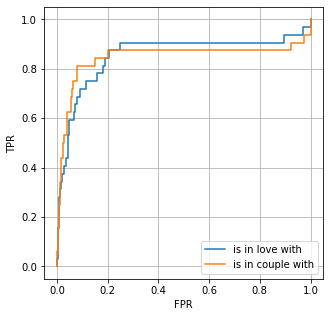

In [9]:
plt.figure(figsize=(5,5))
for v in verb:
    fpr, tpr, thresholds = roc_curve(ans[~ans[v].isnull()].couple_truth.astype(int),
                                     ans[~ans[v].isnull()].loc[:,v])
    plt.plot(fpr,tpr)
plt.grid(True)
plt.legend(verb)
plt.xlabel('FPR')
plt.ylabel('TPR')
auc(fpr,tpr)

0.8416985776805253

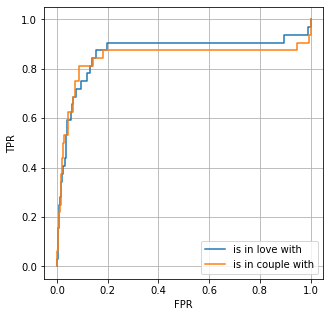

In [11]:
# ROC for couples were both actor/actress are identified and have age information.
plt.figure(figsize=(5,5))
for v in verb:
    fpr, tpr, thresholds = roc_curve(ans[ans[[v,'age_gap']].notnull().all(1)].couple_truth.astype(int),
                                     ans[ans[[v,'age_gap']].notnull().all(1)].loc[:,v])
plt.grid(True)
plt.legend(verb)
plt.xlabel('FPR')
plt.ylabel('TPR')
auc(fpr,tpr)

(array([852., 118.,  68.,  18.,  12.,  14.,  10.,   4.,   1.,   6.]),
 array([6.4594587456667796e-09, 0.09205349073019989, 0.18410697500094103,
        0.2761604592716822, 0.3682139435424233, 0.46026742781316443,
        0.5523209120839057, 0.6443743963546468, 0.7364278806253879,
        0.828481364896129, 0.9205348491668701], dtype=object),
 <BarContainer object of 10 artists>)

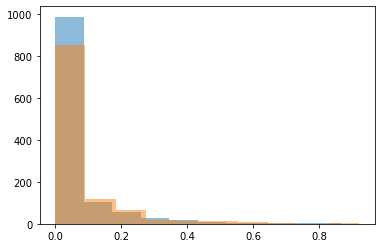

In [12]:
plt.hist(ans[~ans[[v,'age_gap']].notnull().all(1)]['is in love with'],alpha=0.5)
plt.hist(ans[~ans[[v,'age_gap']].notnull().all(1)]['is in couple with'],alpha=0.5)

In [19]:
print(len(ans[(ans['couple_truth']==1)]))
ans[(ans['couple_truth']==1) & (ans[v]<0.3)]

32


,movie,characters,actors,couple_truth,is in love with,is in couple with,age_gap,genders
71,The Quiet American,"[Alden Pyle, Phuong]","[Brendan Fraser, Do Thi Hai Yen]",1,0.056803,0,13.0,"[2, 1]"
152,The Big Lebowski,"[Jeffrey 'The Big' Lebowski, Bunny Lebowski]","[David Huddleston, Tara Reid]",1,0.097300,0.245656,45.0,"[2, 1]"
415,Whatever Works,"[Boris Yellnikoff, Melodie St. Ann Celestine]","[Larry David, Evan Rachel Wood]",1,0.000037,0.000028,40.0,"[2, 1]"
635,Husbands and Wives,"[Gabe Roth, Rain]","[Woody Allen, Juliette Lewis]",1,0.225262,0.148604,37.0,"[2, 1]"
1527,Mr. Peabody and the Mermaid,"[Mr. Peabody, Mermaid]","[William Powell, Ann Blyth]",1,0,0,37.0,"[2, 1]"
1570,First Knight,"[Lancelot, Guinevere]","[Richard Gere, Julia Ormond]",1,0.517337,0.242854,15.0,"[2, 1]"
1638,Something's Gotta Give,"[Julian Mercer, Erica Barry]","[Keanu Reeves, Diane Keaton]",1,0.299178,0.297917,18.0,"[2, 1]"
1854,Eternal Sunshine of the Spotless Mind,"[Dr. Howard Mierzwiak, Mary Svevo]","[Tom Wilkinson, Kirsten Dunst]",1,0.315708,0.100649,35.0,"[2, 1]"
2132,Wild Target,"[Victor Maynard, Rose]","[Bill Nighy, Emily Blunt]",1,0.035917,0.290164,33.0,"[2, 1]"
2205,Hollywood Ending,"[Val, Lori]","[Woody Allen, Debra Messing]",1,0.000001,0.000001,33.0,"[2, 1]"


In [15]:
ans[ans['movie']=='Mr. Peabody and the Mermaid']

,movie,characters,actors,couple_truth,is in love with,is in couple with,age_gap,genders
1527,Mr. Peabody and the Mermaid,"[Mr. Peabody, Mermaid]","[William Powell, Ann Blyth]",1,0,0,37.0,"[2, 1]"
1528,Mr. Peabody and the Mermaid,"[Mr. Peabody, doctor]","[William Powell, None]",False,0.452094,0.135998,NaN,None
1529,Mr. Peabody and the Mermaid,"[Mermaid, Arthur Peabody]","[Ann Blyth, [William Powell, Irene Hervey]]",False,0.199116,0.001563,NaN,None
1530,Mr. Peabody and the Mermaid,"[Mrs. Polly Peabody, Arthur Peabody]","[Irene Hervey, [William Powell, Irene Hervey]]",False,0.000056,0.001029,NaN,None
1531,Mr. Peabody and the Mermaid,"[Cathy Livingston, Arthur Peabody]","[Andrea King, [William Powell, Irene Hervey]]",False,0.002575,0.002135,NaN,None
1532,Mr. Peabody and the Mermaid,"[Mike Fitzgerald, Arthur Peabody]","[Clinton Sundberg, [William Powell, Irene Herv...",False,0.000081,0.000037,NaN,None
1533,Mr. Peabody and the Mermaid,"[Dr. Harvey, Arthur Peabody]","[Art Smith, [William Powell, Irene Hervey]]",False,0.003179,0.052984,NaN,None
1534,Mr. Peabody and the Mermaid,"[Major Hadley, Arthur Peabody]","[Hugh French, [William Powell, Irene Hervey]]",False,0.014001,0.020413,NaN,None
1535,Mr. Peabody and the Mermaid,"[Mother, Arthur Peabody]","[Beatrice Roberts, [William Powell, Irene Herv...",False,0.000201,0.000704,NaN,None
1536,Mr. Peabody and the Mermaid,"[Col. Mandrake, Arthur Peabody]","[Lumsden Hare, [William Powell, Irene Hervey]]",False,0.001958,0.000245,NaN,None


# Issues
- When same character is played by more than one actor/actress (ex: young/old Rose in Titanic)
- Characters' names presented differently at TMDB and Wikipedia (ex: Mr Peabody = Arthur Peabody in Mr. Peabody and the Mermaid)